<a href="https://colab.research.google.com/github/lmVl12/AI_and_Drug_Discovery_Course_2026/blob/main/Assignment_3_Task1_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AI And Biotechnology/Bioinformatics**
## **AI and Drug Discovery Course: QSAR Modeling**


In this task, a comprehensive exploratory analysis of the bioactivity dataset is performed. The primary objective is to evaluate the distribution of $pIC50$ values and identify key molecular descriptors that exhibit statistical significance in distinguishing between active and inactive compounds.

# **Part 2: Exploratory Data Analysis of the FLT3-targeted compounds**

## **1. Environment Setup**

####**Library Imports**

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import rdMolDescriptors
from scipy.stats import mannwhitneyu

## **2. Import Bioactivity Dataset**

The preprocessed bioactivity dataset was saved in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
# Define a path to save plots and files
results_path = "/content/gdrive/My Drive/Colab Notebooks/data/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
df4 = pd.read_csv(results_path + 'bioactivity_preprocessed_data.csv')
df4.head(10)

,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class
0,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3C2CCCCO2)cc1,CHEMBL4208168,1195.000,intermediate
1,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3Cc2ccccc2)cc1,CHEMBL1173420,20000.000,inactive
2,Brc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1,CHEMBL6005160,85.000,active
3,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)n...,CHEMBL3900620,10000.000,inactive
4,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(CC4CCO...,CHEMBL3939018,9886.185,intermediate
5,C#CCN(c1ccc2ncc(-c3cnn(C)c3)nc2c1)c1c(Cl)c(OC)...,CHEMBL3981207,10000.000,inactive
6,C#CCN(c1ccc2ncc(-c3cnn(C)c3)nc2c1)c1c(F)c(OC)c...,CHEMBL3935597,8228.270,intermediate
7,C#CCN1CCc2cc(Nc3ncc(C)c(-c4cnn(C(C)C)c4)n3)ccc2C1,CHEMBL4795467,1480.000,intermediate
8,C#CCOc1ccc(Nc2ccc3ncc(N4CCOCC4)nc3c2C#N)cc1OC,CHEMBL5886106,1000000.000,inactive
9,C#CCn1cc(-c2ccc(NC(=O)Nc3cc(C(C)(C)C)on3)c(F)c...,CHEMBL4483045,46.000,active


## **3. Check for NA Values**

NA values from these columns were successfully removed in Part 1 and this step is just a sanity check.

In [ ]:
initial_count = len(df4)
print(f"Initial number of records:  {initial_count}")
# Check for missing values in ID, SMILES, Value
df_clean = df4.dropna(subset=["molecule_chembl_id", "canonical_smiles", "standard_value"])
dropped_na = initial_count - len(df_clean)
print(f"NaN deleted:                {dropped_na}")  # Should be zero
before_numeric = len(df_clean)
df_clean["standard_value"] = pd.to_numeric(df_clean["standard_value"], errors="coerce")
df_clean = df_clean.dropna(subset=["standard_value"])
dropped_non_numeric = before_numeric - len(df_clean)
print(f"Incorrect values deleted:   {dropped_non_numeric}") # Should be zero

Initial number of records:  4647
NaN deleted:                0
Incorrect values deleted:   0


## **4. Check and Aggregate Duplicates**

####**4.1 IC50 duplicates (median IC50 per canonical smile)**

This step was also presented in Part 1, but it makes sense to do a double-check

In [ ]:
before_agg = len(df4)
df4 = df4.groupby("canonical_smiles", as_index=False).agg({
    "molecule_chembl_id": "first",
    "standard_value": "median",
    "bioactivity_class": "first"
})
print(f"Before aggregation: {before_agg}")
print(f"After aggregation:  {len(df4)}")
print(f"Duplicates removed: {before_agg - len(df4)}")
df4.head()

Before aggregation: 4647
After aggregation:  4647
Duplicates removed: 0


,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class
0,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3C2CCCCO2)cc1,CHEMBL4208168,1195.000,intermediate
1,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3Cc2ccccc2)cc1,CHEMBL1173420,20000.000,inactive
2,Brc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1,CHEMBL6005160,85.000,active
3,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)n...,CHEMBL3900620,10000.000,inactive
4,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(CC4CCO...,CHEMBL3939018,9886.185,intermediate


#### **4.2. SMILES Duplicates**

In [ ]:
print("Duplicate SMILES remaining:",
      df_clean["canonical_smiles"].duplicated().sum())

Duplicate SMILES remaining: 0


## **5. Convert IC50 to pIC50 and reassign the activity labels**

Convert IC50 to the negative logarithmic scale which is essentially -log10(IC50). This conversion allows IC50 data to be more uniformly distributed.

Based on pIC50  
Active >= 6  
Inactive < 6



In [ ]:
# See the initial state of data
total_before = len(df_clean)
intermediate_before = len(df_clean[df_clean["bioactivity_class"] == "intermediate"])

# Transformation
threshold = 6
df_clean["pIC50"] = -np.log10(df_clean["standard_value"] * 1e-9)
df_clean["bioactivity_class"] = np.where(
    df_clean["pIC50"] >= threshold,
    "active",
    "inactive"
)
# Check the state of data after reassignment
total_after = len(df_clean)

# Output
print(f"Initial records count:                        {total_before}")
print(f"Number of 'intermediate' before reassignment: {intermediate_before}")
print("-" * 30)
print(f"Final records count:                          {total_after}")
print(f"Data loss:                                    {total_before - total_after}")
print("-" * 30)
print("New distribution of bioactivity classes:")
print(df_clean["bioactivity_class"].value_counts())
df_clean.head()

Initial records count:                        4647
Number of 'intermediate' before reassignment: 732
------------------------------
Final records count:                          4647
Data loss:                                    0
------------------------------
New distribution of bioactivity classes:
bioactivity_class
active      2936
inactive    1711
Name: count, dtype: int64


,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class,pIC50
0,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3C2CCCCO2)cc1,CHEMBL4208168,1195.000,inactive,5.922632
1,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3Cc2ccccc2)cc1,CHEMBL1173420,20000.000,inactive,4.698970
2,Brc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1,CHEMBL6005160,85.000,active,7.070581
3,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)n...,CHEMBL3900620,10000.000,inactive,5.000000
4,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(CC4CCO...,CHEMBL3939018,9886.185,inactive,5.004971


##**6. Basic Statistics**

Basic descriptive statistics are calculated for the pIC50 values. The distribution is visualized using a histogram to ensure data quality and identify potential outliers. A class frequency plot is generated to evaluate the balance between active and inactive molecules.

This overview shows that the range of IC50 values covers pM to mM scale. The median is lower that 1000 nM threshold which again demonstrates the active-heavy dataset.

Log-transformation normalizes the data distribution, making it more symmetric and reducing the gap between the mean and median. This prevents extreme values (outliers) from skewing the calculations. While it doesn't remove noise, it compresses the scale, significantly lowering the standard deviation and making the min/max range more manageable for modeling.

In [ ]:
df_clean[['standard_value', 'pIC50']].describe()

,standard_value,pIC50
count,4647.000000,4647.000000
mean,29807.677915,6.554864
std,158273.965204,1.466852
min,0.061000,3.000000
25%,19.255000,5.168002
50%,278.000000,6.555955
75%,6792.032500,7.715458
max,1000000.000000,10.214670


In [ ]:
stats_df = df_clean[['standard_value', 'pIC50']].describe()
stats_df.to_csv(results_path + 'pIC50_basic_stats.csv')

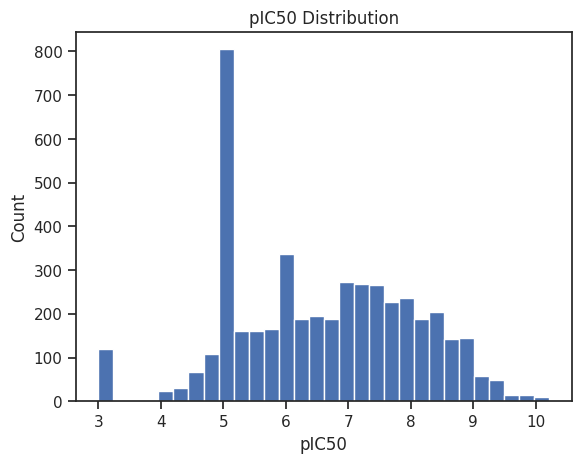

In [ ]:
plt.hist(df_clean["pIC50"], bins=30)
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.title("pIC50 Distribution")
plt.savefig(results_path + 'histogram_pic50.pdf', bbox_inches='tight')
plt.show()

The presence of outliers at the lower boundary ($pIC50 \approx 3$) corresponds to the 1,000,000 nM limit often found in ChEMBL, representing compounds with no measurable inhibitory activity at the highest tested concentration. These data points are essential as they provide the model with 'negative examples,' helping it to distinguish between pharmacologically relevant structures and inactive chemical space.

The distribution also features high-potency outliers with $pIC50$ values exceeding 9.0 (sub-nanomolar activity). While these represent a small fraction of the 4,647 compounds, they are the most pharmacologically significant molecules in the dataset. These outliers provide the 'positive signal' necessary for the model to identify the key structural features responsible for exceptional inhibitory potency.

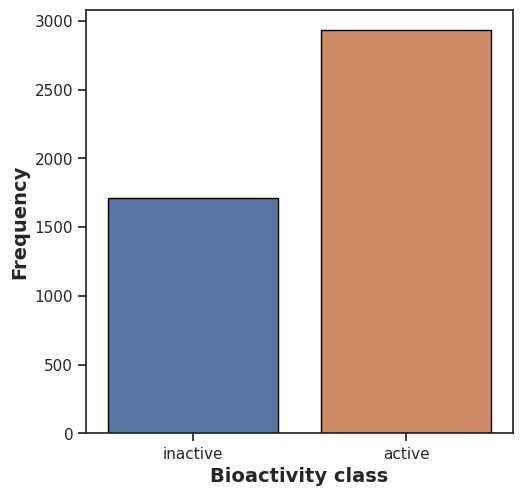

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x="bioactivity_class", data= df_clean, hue="bioactivity_class", edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold');

The final classification following the redistribution of intermediate compounds shows active/inactive ratio. This ratio is crucial for preventing class-imbalance bias during model training. The dataset exhibits a moderate class imbalance but remains robust for machine learning applications

# **7. Lipinski's Descriptor Calculation**

Physicochemical properties, including Molecular Weight, Octanol-Water Partition Coefficient, Hydrogen Bond Donors, and Hydrogen Bond Acceptors, are calculated using RDKit to evaluate the 'drug-likeness' of the compounds according to Lipinski's Rule of Five.

The Lipinski's Rule stated the following:

**Molecular weight < 500 Dalton**  
**Octanol-water partition coefficient (LogP) < 5**  
**Hydrogen bond donors < 5**  
**Hydrogen bond acceptors < 10**

#### 7.1. Preprocess Salts Removal

In Part 1 (Data Acquisition and curation) the salts removal using RDkit SaltRemover was already performed. To be sure no molecule still containes salts (separated by dot) the double-check makes sense.

In [ ]:
salts_found = df_clean.canonical_smiles.str.contains(r'\.').sum()
df_no_smiles = df_clean.drop(columns='canonical_smiles')
smiles = []

for i in df_clean.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key=len)
    smiles.append(cpd_longest)

# Report from Part 1
if salts_found == 0:
    print(f"✅ Check: 0 molecules contain salts. The dataset was clean.")
else:
    print(f"⚠️ Warning: Removed {salts_found} records with salts")
#
smiles = pd.Series(smiles, name='canonical_smiles')
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

df_clean_smiles.head()

✅ Check: 0 molecules contain salts. The dataset was clean.


,molecule_chembl_id,standard_value,bioactivity_class,pIC50,canonical_smiles
0,CHEMBL4208168,1195.000,inactive,5.922632,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3C2CCCCO2)cc1
1,CHEMBL1173420,20000.000,inactive,4.698970,Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3Cc2ccccc2)cc1
2,CHEMBL6005160,85.000,active,7.070581,Brc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1
3,CHEMBL3900620,10000.000,inactive,5.000000,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(C)c3)n...
4,CHEMBL3939018,9886.185,inactive,5.004971,C#CCN(c1cc(OC)cc(OC)c1)c1ccc2ncc(-c3cnn(CC4CCO...


#### **7.2 Calculate descriptors**

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
print("The shape of the dataframe:", df_lipinski.shape)
df_lipinski.head()

The shape of the dataframe: (4647, 4)


,MW,LogP,NumHDonors,NumHAcceptors
0,459.348,3.8681,1.0,8.0
1,465.355,4.2173,1.0,7.0
2,344.216,2.5425,2.0,5.0
3,399.454,3.8188,0.0,7.0
4,483.572,4.7084,0.0,8.0


This function can be done in a different way, the result stays the same

In [ ]:
def lipinski_modern(smiles_list):
  data = []
  for s in smiles_list:
    m = Chem.MolFromSmiles(s)
    if m:
      data.append(
          { "MW": Descriptors.MolWt(m),
           "LogP": Descriptors.MolLogP(m),
            "NumHDonors": Lipinski.NumHDonors(m),
            "NumHAcceptors": Lipinski.NumHAcceptors(m)
            }
          )
  return pd.DataFrame(data)

df_lipinski_modern = lipinski_modern(df_clean_smiles.canonical_smiles)
print("The shape of the dataframe:", df_lipinski_modern.shape)
df_lipinski_modern.head()

The shape of the dataframe: (4647, 4)


,MW,LogP,NumHDonors,NumHAcceptors
0,459.348,3.8681,1,8
1,465.355,4.2173,1,7
2,344.216,2.5425,2,5
3,399.454,3.8188,0,7
4,483.572,4.7084,0,8


####**7.3 Combine Both datasets**

In [ ]:
df_combined = pd.concat([df_clean_smiles, df_lipinski], axis=1)
df_combined = df_combined.drop(columns="standard_value")          # drop the raw IC50 values
df_combined.head()
df_combined.to_csv(results_path + 'df_lipinski.csv', index=False) # save with pIC50 and Lipinski descriptors

## **8. Chemical Space Analysis For Lipinski Descriptors**

#### **8.1 Statistical analysis (Mann-Whitney U Test)**

The Mann-Whitney U test is performed to identify which descriptors are statistically significant with respect to $pIC50$. This non-parametric test determines if there is a significant difference between the distributions of descriptors in active versus inactive classes.

In [ ]:
descriptors = ["NumHAcceptors", "MW", "NumHDonors", "pIC50", "LogP"]
results = []
for desc in descriptors:
    active = df_combined[df_combined['bioactivity_class'] == 'active'][desc]
    inactive = df_combined[df_combined['bioactivity_class'] == 'inactive'][desc]
    stat, p = mannwhitneyu(active, inactive)
    alpha = 0.05
    interpretation = 'Different distribution (reject H0)' if p < alpha else 'Same distribution (fail to reject H0)'

    results.append({
        'Descriptor': desc,
        'Statistics': stat,
        'p': p,
        'alpha': alpha,
        'Interpretation': interpretation
    })

mannwhitney_df = pd.DataFrame(results)
mannwhitney_df

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2211995.5,5.865255e-12,0.05,Different distribution (reject H0)
1,MW,2629345.5,7.677278e-03,0.05,Different distribution (reject H0)
2,NumHDonors,4057871.0,2.876533e-283,0.05,Different distribution (reject H0)
3,pIC50,5023496.0,0.000000e+00,0.05,Different distribution (reject H0)
4,LogP,2346974.0,1.873863e-04,0.05,Different distribution (reject H0)


Based on the Mann-Whitney U test results, all evaluated Lipinski descriptors (MW, LogP, HBD, HBA) are statistically significant ($p < 0.05$). No non-significant descriptors were identified among the core physicochemical properties, although Molecular Weight (MW) showed the highest $p$-value ($7.6 \times 10^{-3}$) among the set, indicating it has the weakest (though still significant) differentiating power.

**Save Statistical Results**

In [ ]:
mannwhitney_df.to_csv(results_path + "mannwhitney_summary.csv", index=False)
print(f"Combined Mann-Whitney CSV saved as mannwhitney_summary.csv")

Combined Mann-Whitney CSV saved as mannwhitney_summary.csv


#### **8.2 Visualization of descriptors distribution**

<Figure size 1500x1000 with 0 Axes>

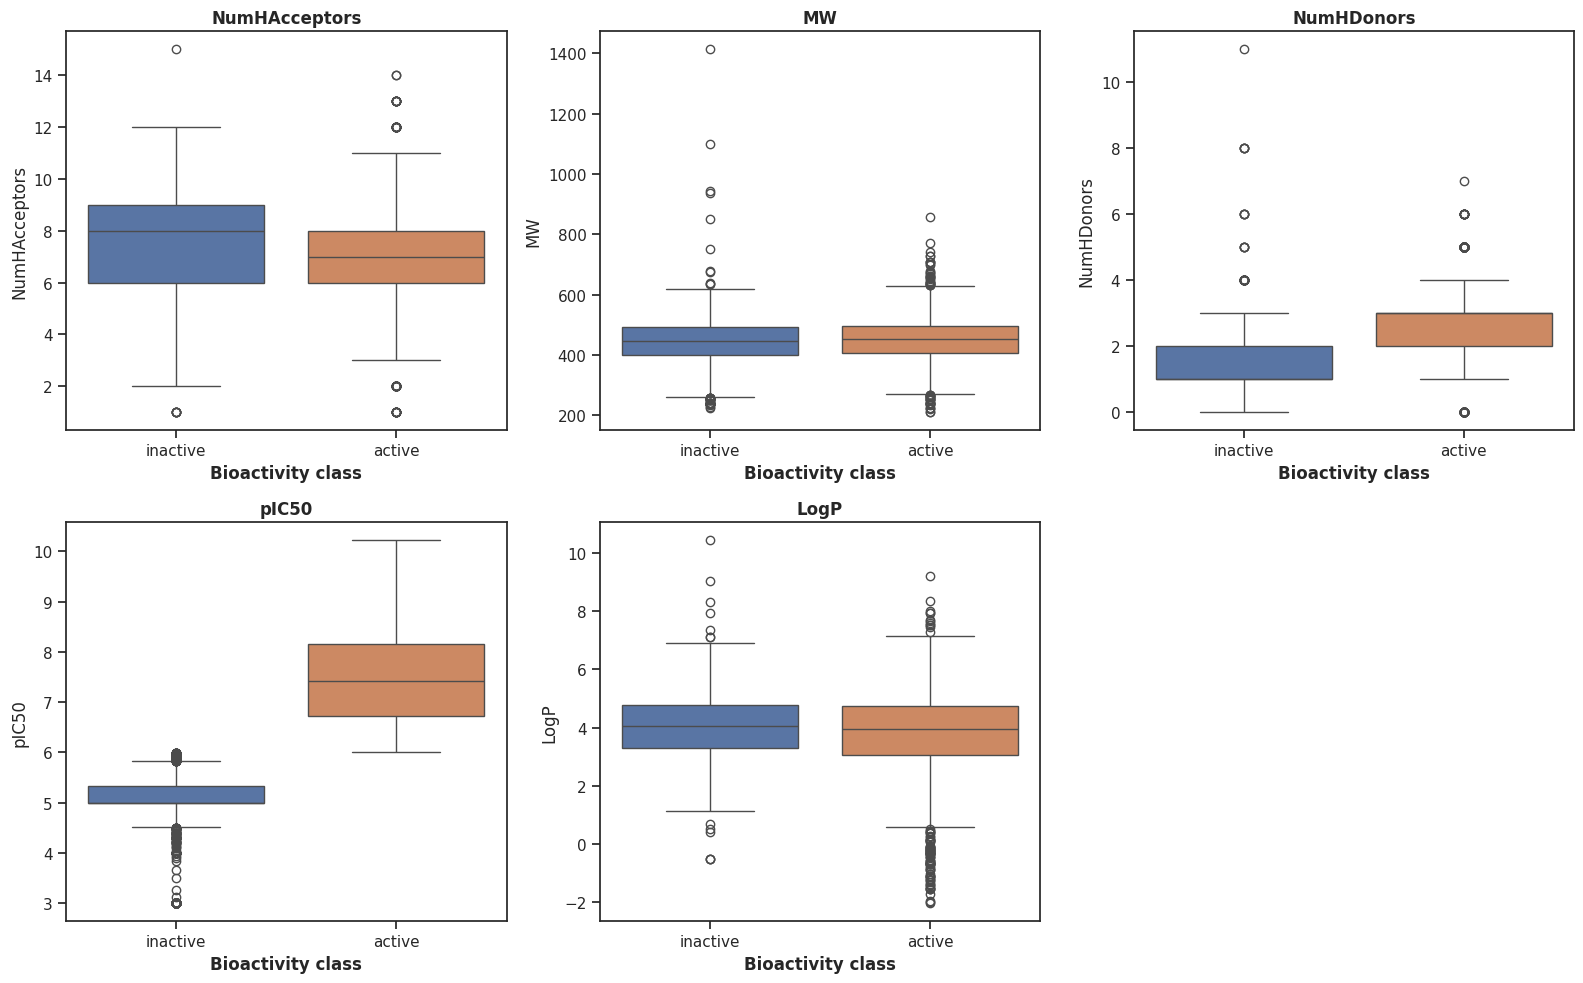

In [ ]:
plt.figure(figsize=(15, 10))

# Create grid for supplots
fig_all, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten() # change the dimension for easy access

for i, desc in enumerate(descriptors):  #create facets with boxplots/descriptor
    sns.boxplot(x='bioactivity_class', y=desc, data=df_combined,
                hue='bioactivity_class', ax=axes[i])
    axes[i].set_title(desc, fontweight='bold')
    axes[i].set_xlabel("Bioactivity class", fontweight='bold')

    temp_fig = plt.figure(figsize=(5.5, 5.5))
    sns.boxplot(x='bioactivity_class', y=desc, data=df_combined, hue='bioactivity_class')
    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel(desc, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save each individual boxplot
    plt.savefig(f"{results_path}boxplot_{desc}.pdf", bbox_inches='tight')
    plt.close(temp_fig) # important for not saving more than 1 plot

axes[-1].axis('off')    # Hide the 6th axes from 3x2 template
plt.tight_layout()
fig_all.savefig(f"{results_path}combined_descriptors_facets.pdf", bbox_inches='tight')
plt.show();

#### **8.3 Conclusions from visualizations**

#####**Molecular Weight**
The boxplot for Molecular Weight (MW) reveals that while both classes share a similar median, the active compounds (orange) are more concentrated within a tighter range, whereas the inactive compounds (blue) show a much broader distribution with significantly higher extreme outliers reaching up to 1400 Da.

##### **Solubility**
For LogP, both active and inactive compounds share a similar central distribution, but the active set (orange) displays a significant cluster of low-lipophilicity outliers (negative LogP), which contrasts with the high-lipophilicity outliers seen in the inactive group.

##### **NumHDonors**
Active compounds generally have more hydrogen bond donors (typically 2 to 3) than inactive ones, which usually have only 1 or 2, as shown by the clear upward shift of the orange box.

##### **NumHAcceptors**
Active compounds tend to have slightly fewer hydrogen bond acceptors

##### **IC50**
The median of active class differs significantly from the inactive class median, which indicates robustness of the dataset. The outliers with extremely low values are those that were seen on the histogram.

#### **8.4 Barplot of the bioactivity classes**

This barplot does not differ from the previous one, since no salts or missing values were removed but still reminds the class ratio in the dataset

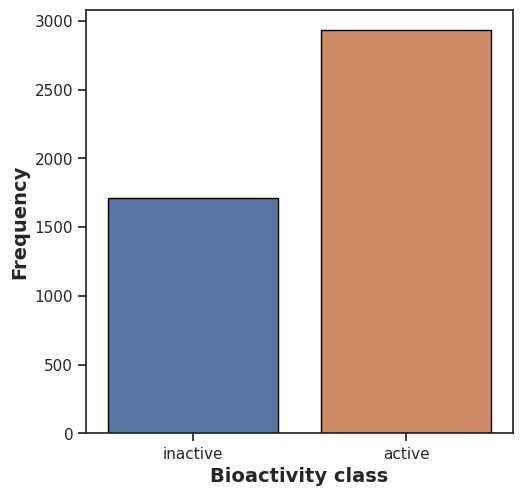

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x="bioactivity_class", data= df_combined, hue="bioactivity_class", edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig(results_path + 'barplot_bioactivity_class.pdf', bbox_inches='tight')

#### **8.5 Scatter of Molecular Weight vs Solubility (LogP)**

The distribution of Molecular Weight vs. Solubility (LogP) shows considerable overlap between active and inactive compounds. This suggests that for this specific protein target, neither molecular size nor solubility is the primary determinant of inhibitory activity. Both groups remain largely within the Lipinski-compliant range (under 500 Da). There is a clear positive correlation between Molecular Weight and LogP: as the molecules get heavier (higher MW), they generally become more lipophilic (higher LogP).

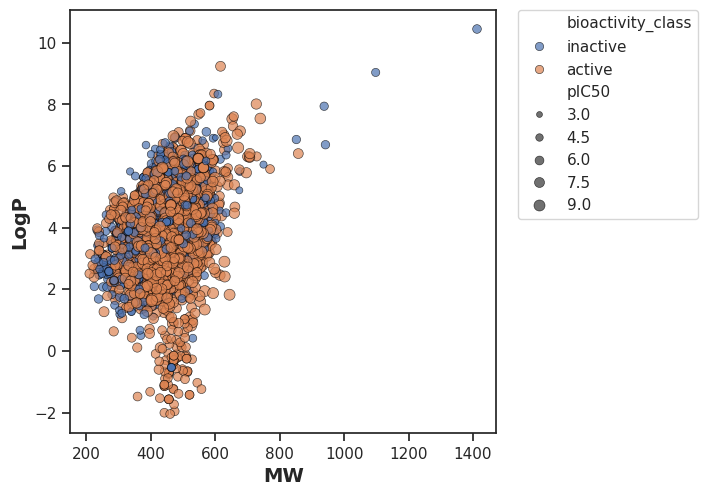

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(
    x='MW', y='LogP',
    data=df_combined,
    hue='bioactivity_class',
    size='pIC50', edgecolor='black',
    alpha=0.7
)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig(results_path + 'scatter_plot_MW_vs_LogP.pdf', bbox_inches='tight')

## **9. Save & Downlaod Results**

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/data/"
! zip -r EDA_results.zip . -i *df_lipinski.csv *mannwhitney_summary.csv *.pdf *pIC50_basic_stats.csv
%cd /content/
print(f"All the outuput files were archived and saved")

/content/gdrive/My Drive/Colab Notebooks/data
updating: pIC50_basic_stats.csv (deflated 33%)
updating: histogram_pic50.pdf (deflated 31%)
updating: df_lipinski.csv (deflated 78%)
updating: mannwhitney_summary.csv (deflated 50%)
updating: boxplot_NumHAcceptors.pdf (deflated 38%)
updating: boxplot_MW.pdf (deflated 37%)
updating: boxplot_NumHDonors.pdf (deflated 38%)
updating: boxplot_pIC50.pdf (deflated 33%)
updating: boxplot_LogP.pdf (deflated 37%)
updating: combined_descriptors_facets.pdf (deflated 33%)
updating: barplot_bioactivity_class.pdf (deflated 38%)
updating: scatter_plot_MW_vs_LogP.pdf (deflated 2%)
/content
All the outuput files were archived and saved
